In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from catboost import CatBoostRegressor

In [2]:
# Loading the Data (NASA C-MAPSS dataset)
train_data_fd001 = pd.read_csv('CMAPSSData/train_FD001.txt', header=None, delimiter=' ')
train_data_fd002 = pd.read_csv('CMAPSSData/train_FD002.txt', header=None, delimiter=' ')
train_data_fd003 = pd.read_csv('CMAPSSData/train_FD003.txt', header=None, delimiter=' ')
train_data_fd004 = pd.read_csv('CMAPSSData/train_FD004.txt', header=None, delimiter=' ')

test_data_fd001 = pd.read_csv('CMAPSSData/test_FD001.txt', header=None, delimiter=' ')
test_data_fd002 = pd.read_csv('CMAPSSData/test_FD002.txt', header=None, delimiter=' ')
test_data_fd003 = pd.read_csv('CMAPSSData/test_FD003.txt', header=None, delimiter=' ')
test_data_fd004 = pd.read_csv('CMAPSSData/test_FD004.txt', header=None, delimiter=' ')

rul_data_fd001 = pd.read_csv('CMAPSSData/RUL_FD001.txt', header=None, delimiter=',')
rul_data_fd002 = pd.read_csv('CMAPSSData/RUL_FD002.txt', header=None, delimiter=',')
rul_data_fd003 = pd.read_csv('CMAPSSData/RUL_FD003.txt', header=None, delimiter=',')
rul_data_fd004 = pd.read_csv('CMAPSSData/RUL_FD004.txt', header=None, delimiter=',')

In [3]:
def add_dataset_id(df, dataset_name):
    df['dataset_id'] = dataset_name
    return df

# Processing training data
train_data_fd001 = add_dataset_id(train_data_fd001, 'FD001')
train_data_fd002 = add_dataset_id(train_data_fd002, 'FD002')
train_data_fd003 = add_dataset_id(train_data_fd003, 'FD003')
train_data_fd004 = add_dataset_id(train_data_fd004, 'FD004')

# Processing test data
test_data_fd001 = add_dataset_id(test_data_fd001, 'FD001')
test_data_fd002 = add_dataset_id(test_data_fd002, 'FD002')
test_data_fd003 = add_dataset_id(test_data_fd003, 'FD003')
test_data_fd004 = add_dataset_id(test_data_fd004, 'FD004')

# Combining all the data
train_data = pd.concat([train_data_fd001, train_data_fd002, train_data_fd003, train_data_fd004], axis=0, ignore_index=True)
test_data = pd.concat([test_data_fd001, test_data_fd002, test_data_fd003, test_data_fd004], axis=0, ignore_index=True)
rul_data = pd.concat([rul_data_fd001, rul_data_fd002, rul_data_fd003, rul_data_fd004], axis=0, ignore_index=True)

In [4]:
# Data Cleaning and Preprocessing
train_data.drop(columns=[26, 27], inplace=True)
test_data.drop(columns=[26, 27], inplace=True)

column_names = ["unit_number","time_in_cycles","operational_set_1","operational_set_2","operational_set_3",
                "T2","T24","T30","T50","P2","P15","P30","Nf","Nc","epr","Ps30","phi","NRf","NRc","BPR","farB","htBleed",
                "Nf_dmd","PCNfR_dmd","W31","W32", 'dataset_id']
train_data.columns = column_names
test_data.columns = column_names
rul_data.columns = ['RUL']

# Filling missing values
train_data.fillna(train_data.mean(), inplace=True)
test_data.fillna(test_data.mean(), inplace=True)

# Calculate Remaining Useful Life (RUL)
train_data['RUL'] = train_data.groupby('unit_number')['time_in_cycles'].transform(max) - train_data['time_in_cycles']
train_data = pd.merge(train_data, rul_data, how='left', left_on='unit_number', right_index=True)
train_data['RUL'] = train_data[['RUL_x', 'RUL_y']].min(axis=1)
train_data.drop(columns=['RUL_x', 'RUL_y'], inplace=True)

In [5]:
# Feature Engineering (Time-series Features)
def create_time_series_features(df):
    df['lag_1'] = df['RUL'].shift(1)
    df['rolling_mean_3'] = df['RUL'].rolling(3).mean()
    df['rolling_std_3'] = df['RUL'].rolling(3).std()
    df['rolling_mean_5'] = df['RUL'].rolling(5).mean()
    df['rolling_std_5'] = df['RUL'].rolling(5).std()
    return df

train_data = create_time_series_features(train_data)
train_data.fillna(0, inplace=True)

In [6]:
# Prepare Features and Target
X = train_data.drop(['unit_number', 'time_in_cycles', 'RUL'], axis=1)
y = train_data['RUL']

# One-hot encode the dataset_id to treat it as a categorical variable
X = pd.get_dummies(X, columns=['dataset_id'], drop_first=True)

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
# Model Training (Linear Regression, Random Forest, XGBoost, CatBoost)
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 1. Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))

# 2. Random Forest
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

# 3. XGBoost
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))

# 4. CatBoost
catboost_model = CatBoostRegressor(learning_rate=0.05, iterations=1000, depth=10, verbose=0)
catboost_model.fit(X_train, y_train)
y_pred_catboost = catboost_model.predict(X_test)
print("CatBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_catboost)))

Linear Regression RMSE: 1.6275143536528833
Random Forest RMSE: 1.2846103080999807
XGBoost RMSE: 0.9753202381995089
CatBoost RMSE: 0.7472865908091163


In [8]:
# Model Evaluation
rmse_values = {
    'Linear Regression': np.sqrt(mean_squared_error(y_test, y_pred_lr)),
    'Random Forest': np.sqrt(mean_squared_error(y_test, y_pred_rf)),
    'XGBoost': np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
    'CatBoost': np.sqrt(mean_squared_error(y_test, y_pred_catboost))
}

# Sorting RMSE values to get the best models
sorted_rmse = sorted(rmse_values.items(), key=lambda x: x[1])
print("Sorted RMSE values (Best models first):")
for model, rmse in sorted_rmse:
    print(f"{model}: {rmse}")

Sorted RMSE values (Best models first):
CatBoost: 0.7472865908091163
XGBoost: 0.9753202381995089
Random Forest: 1.2846103080999807
Linear Regression: 1.6275143536528833


In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

# Create a list of models for stacking
base_learners = [
    ('rf', RandomForestRegressor(n_estimators=100)),
    ('xgb', xgb.XGBRegressor()),
    ('catboost', CatBoostRegressor(learning_rate=0.05, iterations=1000, depth=10, verbose=0)),
]
meta_learner = LinearRegression()

stacking_model = StackingRegressor(estimators=base_learners, final_estimator=meta_learner)
stacking_model.fit(X_train, y_train)
y_pred_stacking = stacking_model.predict(X_test)
print("Stacking RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_stacking)))

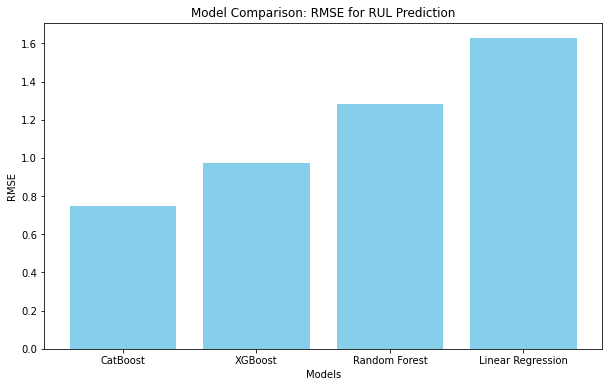

In [9]:
# Model Comparison Plot
plt.figure(figsize=(10, 6))
models = [model for model, _ in sorted_rmse]
rmse_vals = [rmse for _, rmse in sorted_rmse]
plt.bar(models, rmse_vals, color='skyblue')
plt.title('Model Comparison: RMSE for RUL Prediction')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.show()

In [10]:
# Reshape data for LSTM (samples, timesteps, features)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=32, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer=Adam(), loss='mean_squared_error')

lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test))

# Predicting with the LSTM
y_pred_lstm = lstm_model.predict(X_test_lstm)
print("LSTM RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lstm)))

Epoch 1/50
4009/4009 [==============================] - 15s 3ms/step - loss: 2090.9448 - val_loss: 500.4193
Epoch 2/50
4009/4009 [==============================] - 12s 3ms/step - loss: 242.6861 - val_loss: 61.7653
Epoch 3/50
4009/4009 [==============================] - 12s 3ms/step - loss: 85.3050 - val_loss: 16.8129
Epoch 4/50
4009/4009 [==============================] - 11s 3ms/step - loss: 63.7308 - val_loss: 9.7271
Epoch 5/50
4009/4009 [==============================] - 11s 3ms/step - loss: 55.7687 - val_loss: 7.3351
Epoch 6/50
4009/4009 [==============================] - 11s 3ms/step - loss: 51.6906 - val_loss: 5.8744
Epoch 7/50
4009/4009 [==============================] - 13s 3ms/step - loss: 48.2748 - val_loss: 5.5507
Epoch 8/50
4009/4009 [==============================] - 13s 3ms/step - loss: 45.6944 - val_loss: 4.2199
Epoch 9/50
4009/4009 [==============================] - 13s 3ms/step - loss: 43.5129 - val_loss: 3.3266
Epoch 10/50
4009/4009 [==============================] - 

In [12]:
gru_model = Sequential()
gru_model.add(GRU(units=64, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(units=32, return_sequences=False))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(1))
gru_model.compile(optimizer=Adam(), loss='mean_squared_error')

gru_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test))

# Predicting with the GRU
y_pred_gru = gru_model.predict(X_test_lstm)
print("GRU RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gru)))

Epoch 1/50
4009/4009 [==============================] - 16s 3ms/step - loss: 1619.3101 - val_loss: 264.2142
Epoch 2/50
4009/4009 [==============================] - 12s 3ms/step - loss: 152.6113 - val_loss: 32.7049
Epoch 3/50
4009/4009 [==============================] - 13s 3ms/step - loss: 75.2566 - val_loss: 13.8358
Epoch 4/50
4009/4009 [==============================] - 12s 3ms/step - loss: 61.8027 - val_loss: 7.4170
Epoch 5/50
4009/4009 [==============================] - 13s 3ms/step - loss: 56.3708 - val_loss: 5.8675
Epoch 6/50
4009/4009 [==============================] - 13s 3ms/step - loss: 53.0979 - val_loss: 4.9667
Epoch 7/50
4009/4009 [==============================] - 13s 3ms/step - loss: 49.9334 - val_loss: 5.4559
Epoch 8/50
4009/4009 [==============================] - 13s 3ms/step - loss: 47.5468 - val_loss: 3.7380
Epoch 9/50
4009/4009 [==============================] - 13s 3ms/step - loss: 45.6462 - val_loss: 9.1741
Epoch 10/50
4009/4009 [==============================] - 

catboost alone stands as the best model across all !